### Import Libraries

In [1]:
import numpy as np
import random
import string
import re
import requests
import os
import copy
import matplotlib as plt
from more_itertools import sort_together

###Function for Substitution Cipher & Encoder

In [2]:
def generate_cipher(seed_):

  if seed_ != "OFF":
  #Random settings for reproducability
    random.seed(seed_)
    first_state = random.getstate()
    random.setstate(first_state)

  #Create cipher alphabet and rearrange randomly
  cipher_alphabet = list(string.ascii_lowercase)
  random.shuffle(cipher_alphabet)

  #create alphabet
  alphabet = list(string.ascii_lowercase)

  #generate mapping dictionary
  dict_map = {}
  for real, encoded in zip(alphabet, cipher_alphabet):
    dict_map[real] = encoded
  
  return(dict_map)

#Generate same cipher as worked example
def generate_cipher_ex():
  cipher_alphabet = ['f', 'r', 'z', 's', 'b', 'h', 'q', 'p', 'c', 'n', 'k', 'd', 'o', 'u', 'e', 'x', 'w', 'i','t', 'l', 'a','m','g', 'v', 'j','y']
  alphabet = list(string.ascii_lowercase)
  
  #generate mapping dictionary
  dict_map = {}
  for real, encoded in zip(alphabet, cipher_alphabet):
    dict_map[real] = encoded
  
  return(dict_map)

#function to generate list of ciphers
def generate_cipher_set(num_cipher):
  ciphers = []
  for _ in range(num_cipher):
    ciphers.append(generate_cipher("OFF"))
  return(ciphers)

def mutate_cipher(ciphers_, offspring):
  ciphers_copy = copy.deepcopy(ciphers_)

  for cipher_ in ciphers_:
    #copy dictionary
    cipher_copy = copy.deepcopy(cipher_)

    for x in range(offspring):
      #select a pair of dictionary keys
      keys_ = random.choices(list(cipher_copy.keys()), k=2)
      v0 = cipher_copy[keys_[0]]
      v1 = cipher_copy[keys_[1]]

      #swap key value pair
      cipher_copy[keys_[0]] = v1
      cipher_copy[keys_[1]] = v0

      #append new cipher to dictionary of ciphers
      ciphers_copy.append(cipher_copy)
  
  return(ciphers_copy)

def execute_cipher(cipher, text):
  encoded_text = []
  for word in text:
    encoded_word = []
    for letter in word:
      encoded_word.append(cipher[letter])
    encoded_word = "".join(encoded_word)
    encoded_text.append(encoded_word)
  return(encoded_text)

def read_in(message):
  message = message.lower().replace(".","").replace(",","").replace("-", " ").rstrip().split('\n')
  message_decrypt = []
  for line in message:
    for word in line.split(" "):
      message_decrypt.append(word)
  return(message_decrypt)


### Language Model Class

In [3]:
class language_model():

  def __init__(self,text):
    #generate initial state distribution, pi, and transition matrix, A
    self.pi = np.zeros(26)
    self.A = np.ones((26,26))

    #generate dictionary to map letter to numerical position in alphabet
    dict_ = {}
    for idx, letter in enumerate(list(string.ascii_lowercase)):
      dict_[letter] = idx

    #calculate counts of each letter
    if type(text) == str:
      text = text.split()

    for line in text:
      for word in line:
        for idx, letter in enumerate(word):
          if idx == 0:
            self.pi[dict_[letter]] += 1
          elif idx > 0:
            prev_letter = word[idx-1]
            self.A[dict_[prev_letter], dict_[letter]] += 1
      
    #calculate probabilities and use plus one smoothing on transition matrix A
    self.A /= self.A.sum(axis =1, keepdims= True)
    self.pi /= self.pi.sum()

    #pass to class
    self.A_log = np.log(self.A)
    self.pi_log = np.log(self.pi)
    self.dict_ = dict_
  
  def log_prob(self, text):
    if type(text) == str:
      text = text.split()

    for word_count, word in enumerate(text):
      for idx, letter in enumerate(word):
        if idx == 0 and word_count == 0 :
          log_prob = np.log(self.pi[self.dict_[letter]])
        if idx == 0 and word_count > 0:
          log_prob += np.log(self.pi[self.dict_[letter]])
        elif idx > 0:
          prev_letter = word[idx-1]
          log_prob += np.log(self.A[self.dict_[prev_letter], self.dict_[letter]])
    
    return(log_prob)

### Read in moby dick

In [4]:
#replace non alpha characters
regex = re.compile('[^a-zA-Z]')

text = []

with open('/content/drive/MyDrive/Colab Notebooks/JHub/Module 5/moby_dick.txt', 'r') as f:
  for line in f:
    line = line.rstrip()

    if line:
      line = regex.sub(" ", line) #replace all non-alpha characters with space
      tokens = line.lower().split()
      text.append(tokens)


###Read in message for encryption and decryption

In [5]:
original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

###Run functions

In [6]:
#instantiate language model class
lm = language_model(text)

#Generate decrypted message
message = read_in(original_message)

#Encrypt string using generated cipher
message_encrypt = execute_cipher(generate_cipher_ex(), message)

#Calculate log probability using language model
lm.log_prob(message)

-933.0312453751819

###Genetic Algorithm

In [11]:
iterations = 1000
ciphers = generate_cipher_set(20)
score = []

for iter in range(iterations):

  #if past the first iteration, perform 3 mutations on each cipher and append to list
  if iter > 0:
    ciphers = mutate_cipher(ciphers, 3)
  
  #calculate the log likelihood for each cipher message decryption in the cipher set using the 
  log_l = [lm.log_prob(execute_cipher(cipher_test, message_encrypt)) for cipher_test in ciphers]

  #sort list of ciphers according to lowest log likelihood score and slice the list by top 5
  ciphers = list(sort_together([log_l,ciphers], reverse=True)[1])[0:5]

  #append best log likelihood score to the scores list
  score.append((sorted(log_l, reverse=True)[0]))


In [ ]:
score[999]

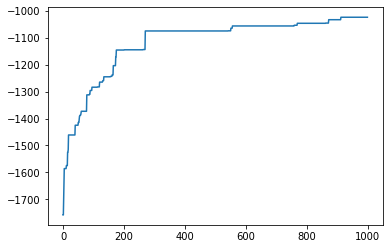

In [14]:
plt.pyplot.plot(list(range(iterations)), score)
plt.pyplot.show()